# Predicting Code Bugs (S3E23)

https://www.kaggle.com/competitions/playground-series-s3e23

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import randint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [76]:
# Seaborn
rc = {
    "axes.facecolor": "#243139",
    "figure.facecolor": "#243139",
    "axes.edgecolor": "#000000",
    "grid.color": "#000000",
    "font.family": "arial",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [77]:
original = pd.read_csv('data/jm1.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
n_cols = train.columns[1:-1] #Pertinent training variables

#Null Values in Each df
dataframes = {'original': original, 'train': train, 'test': test}
result = {name: df.isna().sum() for name, df in dataframes.items()}
result_df = pd.DataFrame(result)
result_df

,original,train,test
b,0.00,0,0.00
branchCount,0.00,0,0.00
d,0.00,0,0.00
defects,0.00,0,NaN
e,0.00,0,0.00
ev(g),0.00,0,0.00
i,0.00,0,0.00
id,NaN,0,0.00
iv(g),0.00,0,0.00
l,0.00,0,0.00


In [78]:
plt.figure(figsize=(16, len(n_cols) * 3))

for i, col in enumerate(n_cols):
    # Plotting for outcome
    plt.subplot(len(n_cols), 2, i+1)
    sns.histplot(x=col, hue="defects", data=train, bins=30, kde=True, palette='mako')
    plt.title(f"{col} distribution for outcome", fontweight="bold", color = 'white')
    plt.ylim(0, train[col].value_counts().max() + 10)
    
    
    plt.legend(title="Defects", loc='upper right', labels=['true', 'false'], labelcolor='white').get_title().set_color("white")
    
plt.tight_layout()
plt.show()

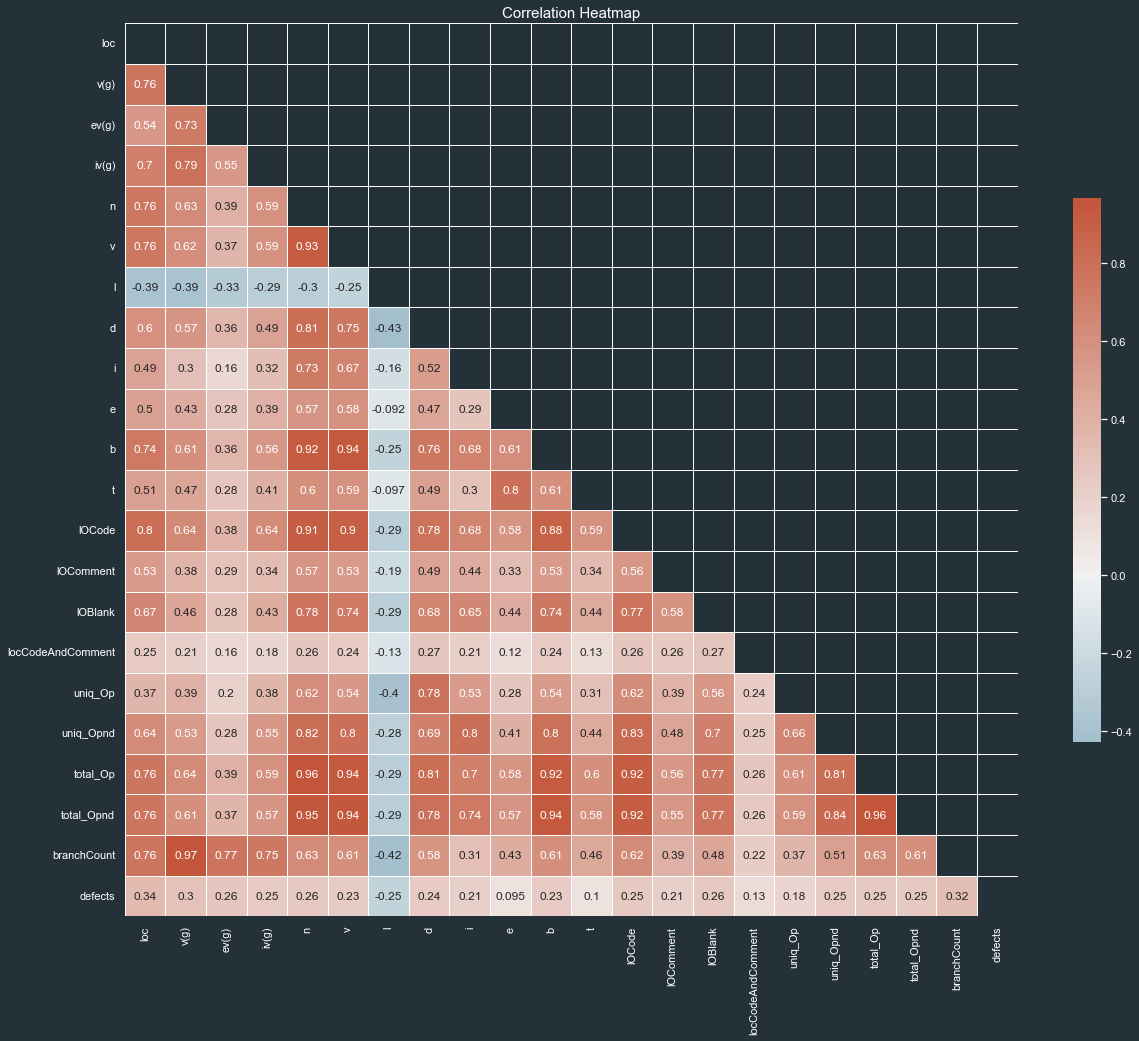

In [ ]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(20, 20))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr, mask=mask,  center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, cmap=cmap)

    plt.title("Correlation Heatmap", size=15, color='white')
    plt.show()

plot_correlation_heatmap(train.drop(columns='id'))

In [ ]:
train = pd.concat([train, original], ignore_index=True)
train.drop_duplicates(inplace=True)

train.dtypes

id                   float64
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op               object
uniq_Opnd             object
total_Op              object
total_Opnd            object
branchCount           object
defects                 bool
dtype: object

In [ ]:
def clean_entries(df: pd.DataFrame) -> pd.DataFrame:
    for col in ['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']:
        df = df[pd.to_numeric(df[col], errors='coerce').notna()]
        df[col] = df[col].astype(float)
    return df


train = clean_entries(train).dropna()
test = clean_entries(test)

C:\Users\chase\AppData\Local\Temp\ipykernel_30296\1361703711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)


In [ ]:
X = train.drop(columns=['id','defects'])
y = train['defects'].astype(int)  # Convert 'true'/'false' to 1/0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_submission = test.drop(columns=['id'])

## Models

In [ ]:
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),  # verbose=0 to prevent too many printouts
}

param_map = {
    "RandomForest": {
        'n_estimators': randint(50, 200),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': randint(1, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    },
    "ExtraTrees": {
        'n_estimators': randint(50, 200),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': randint(1, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    },
    "HistGradientBoosting": {
        'max_iter': randint(50, 200),
        'max_depth': randint(1, 10),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    },
    "XGB": {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
    },
    "LGBM": {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
    },
    "CatBoost": {
        'iterations': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bylevel': [0.5, 0.7, 1],
    }
}


In [ ]:
results = {}
best_models = {}
best_params = {}

n_iter_search = 20 
cv_folds = 5        

for name, clf in classifiers.items():

    if name in param_map:
        random_search = RandomizedSearchCV(clf, param_distributions=param_map[name],
                                           n_iter=n_iter_search, scoring='roc_auc', cv=cv_folds, 
                                           verbose=1, n_jobs=-1)
        random_search.fit(X_train, y_train)
        
        # Use the best estimator
        best_clf = random_search.best_estimator_
        best_params[name] = random_search.best_params_
    else:
        best_clf = clf
        best_clf.fit(X_train, y_train)
    
    # Predict probabilities for the positive class
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    
    # Compute AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = auc
    best_models[name] = best_clf
    print(f"{name} AUC: {auc:.4f}")

# Sort and display results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
print("\nClassifiers ranked by AUC:")
for name, auc in sorted_results.items():
    print(f"{name}: {auc:.4f}")

RandomForest AUC: 0.7658
ExtraTrees AUC: 0.7589
HistGradientBoosting AUC: 0.7877
XGB AUC: 0.7807
[LightGBM] [Info] Number of positive: 18536, number of negative: 62874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3559
[LightGBM] [Info] Number of data points in the train set: 81410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227687 -> initscore=-1.221418
[LightGBM] [Info] Start training from score -1.221418
LGBM AUC: 0.7876
CatBoost AUC: 0.7866

Classifiers ranked by AUC:
HistGradientBoosting: 0.7877
LGBM: 0.7876
CatBoost: 0.7866
XGB: 0.7807
RandomForest: 0.7658
ExtraTrees: 0.7589


In [ ]:
#Ensemble of predictions for each result
proba_preds = []

for name, clf in classifiers.items():
    proba_preds.append(clf.predict_proba(X_submission)[:, 1])

proba_preds = np.array(proba_preds).T
average_proba = proba_preds.mean(axis=1)

In [ ]:
submission = pd.concat([test['id'], pd.Series(average_proba)], axis=1)
submission.columns = ['id', 'probability']
submission.to_csv('submission.csv', index=False)